In [2]:
import numpy as np
import os
import trimesh
from trimesh.sample import sample_surface_sphere
from trimesh.ray.ray_pyembree import RayMeshIntersector
from shapely.geometry import LineString
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from open3d import *
import math
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
DATA_DIR = '../../data/Experiment-Cube-multi-phase'
# synsetId = '02691156'
# modelId = 'afc2efb530e899634d4cb1c2a5e48b7a'

# MODEL_DIR = os.path.join(DATA_DIR, synsetId, modelId, 'models')
# STATS = os.path.join(MODEL_DIR, 'model_normalized.json')
# MESH = os.path.join(MODEL_DIR, 'model_normalized.obj')
# MATERIALS = os.path.join(MODEL_DIR, 'model_normalized.mtl')
# FULL_VOXELS = os.path.join(MODEL_DIR, 'model_normalized.solid.binvox')
# SURF_VOXELS = os.path.join(MODEL_DIR, 'model_normalized.surface.binvox')
MESH = os.path.join(DATA_DIR, 'cube_up.obj')

In [4]:
mesh = trimesh.load_mesh(MESH)
mesh.show()

/home/nikoloside/.pyenv/versions/anaconda3-2020.11/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [98]:
mesh.is_watertight

False

In [99]:
mesh.bounds

array([[-0.502146, -0.502621, -0.197937],
       [ 0.50212 ,  0.502644,  0.500179]])

In [100]:
class MeshSampler:
    def __init__(self, mesh, check_faces=False):
        self.mesh = mesh
        self.sphere_points = trimesh.sample.sample_surface(mesh.bounding_sphere, count=1000)[0]*2
        self.correct_faces = {i:0 for i in range(len(mesh.faces))}
        self.ray_mesh = RayMeshIntersector(geometry=mesh)
        self.faces_centroids = self.mesh.triangles.mean(axis=1)
        self.correct_points = np.array([])
        if check_faces:
            self.compute_visible_faces()
        else:
            self.correct_faces = {i:1 for i in range(len(mesh.faces))}
    
    def visible_faces(self):
        return self.correct_faces
        
    def compute_visible_faces(self):
        for i, face in enumerate(tqdm(self.mesh.triangles)):
            for point in face:
                ray_directions = -(self.sphere_points - point)
                faces_hit = self.ray_mesh.intersects_first(self.sphere_points, ray_directions)
                if i in faces_hit:
                    self.correct_faces[i] = 1
        return self.correct_faces
    
    def sample_points(self, n_points=10000):
        points = trimesh.sample.sample_surface(self.mesh, count=n_points)
        correct_points = []
        normals_for_points = []
        for i, point in enumerate(tqdm(points[0])):
            if self.correct_faces[points[1][i]] == 1:
                correct_points += [point]
                normals_for_points += [self.mesh.face_normals[points[1][i]]]
        self.correct_points = np.array(correct_points)
        self.normals_for_points = np.array(normals_for_points)
        return self.correct_points
    
    def compute_sdf(self, sigma=0.0025):
        noise = np.random.normal(0, sigma, self.correct_points.shape)
        noisy_points = self.correct_points + noise
        sdf = self.mesh.nearest.signed_distance(noisy_points)
        correct_mesh_points = []
        correct_sdf = []
        correct_normals = []
        for i, distance in enumerate(sdf):
            if math.isnan(distance):
                continue
            else:
                correct_mesh_points += [noisy_points[i]]
                correct_sdf += [sdf[i]]
                correct_normals += [self.normals_for_points[i]]
        return np.array(correct_mesh_points), np.array(correct_sdf), np.array(correct_normals)

In [101]:
a = MeshSampler(mesh, check_faces=False)

In [102]:
print('All faces:', len(mesh.faces))
print('Visible faces:', len(a.visible_faces()))
print('Ratio of invisible faces:', (len(mesh.faces)-len(a.visible_faces()))/len(mesh.faces))

All faces: 90570
Visible faces: 90570
Ratio of invisible faces: 0.0


In [103]:
points = a.sample_points(250000)

<ipython-input-100-312f1c59bc08>:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, point in enumerate(tqdm(points[0])):


In [104]:
points = np.array(points)

In [105]:
len(points)

250000

In [106]:
points, sdf, normals = a.compute_sdf(0.03)

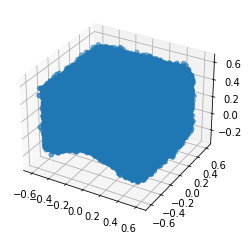

In [107]:
trimesh.points.plot_points(points)

In [108]:
np.save(os.path.join(DATA_DIR, 'points.npy'), np.array(points))

In [109]:
points

array([[-0.4524377 , -0.47667146, -0.0869388 ],
       [ 0.48905204,  0.2859885 ,  0.15680013],
       [ 0.19585384,  0.18209624, -0.2573915 ],
       ...,
       [-0.46603071,  0.49920781,  0.06938985],
       [-0.05809292, -0.50890917,  0.40330035],
       [ 0.47558609, -0.08891425,  0.23169137]])

In [110]:
rows, columns = points.shape

In [111]:
f1point = np.c_[points, np.ones(rows)]

In [112]:
f1point

array([[-0.4524377 , -0.47667146, -0.0869388 ,  1.        ],
       [ 0.48905204,  0.2859885 ,  0.15680013,  1.        ],
       [ 0.19585384,  0.18209624, -0.2573915 ,  1.        ],
       ...,
       [-0.46603071,  0.49920781,  0.06938985,  1.        ],
       [-0.05809292, -0.50890917,  0.40330035,  1.        ],
       [ 0.47558609, -0.08891425,  0.23169137,  1.        ]])

In [113]:
np.save(os.path.join(DATA_DIR, 'f1points.npy'), np.array(f1points))

In [123]:
region = 0

In [114]:
f1sdf = (sdf + 1) / 2 + region

In [115]:
f1sdf

array([0.51031031, 0.50540264, 0.46146152, ..., 0.50027876, 0.49556323,
       0.51219904])

In [116]:
np.amin(f1sdf)

0.43673355176868034

In [117]:
np.amax(f1sdf)

0.5686485532322475

In [118]:
f1sdf = f1sdf / 2

In [119]:
np.save(os.path.join(DATA_DIR, 'sdf.npy'), np.array(sdf))

In [120]:
np.save(os.path.join(DATA_DIR, 'f1sdf.npy'), np.array(f1sdf))

In [121]:
np.save(os.path.join(DATA_DIR, 'normals.npy'), np.array(normals))

In [122]:
normals

array([[ 4.11703471e-01,  2.51502537e-02, -9.10970755e-01],
       [ 9.99999636e-01, -8.47358406e-04, -1.01319128e-04],
       [-7.66171765e-02, -1.82069366e-01, -9.80296156e-01],
       ...,
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-9.25116535e-04, -9.99999572e-01,  2.58325942e-05],
       [ 9.99999939e-01,  1.25292501e-04, -3.25265732e-04]])